In [12]:
import aquamonitor as am
import pandas as pd
import nivapy3 as nivapy
import altair as alt
import datetime as dt
from bs4 import BeautifulSoup

am.host = "https://test-aquamonitor.niva.no/"
am.aqua_site = "admin/"

## 1. Login

In [2]:
token = am.login()

Username:  ···
Password:  ··············


Login successful.


## 2. Get all Labware "projects" for 1000 Lakes Survey

Note that a "project" in Labware is not the same as a "project" in AM.

In [3]:
# Get Labware projects
proj_df = am.get_labware_projects(token, '190091;3')

proj_df.head()

,name,status,closed
0,930-8265,I,False
1,930-8268,I,False
2,930-8269,P,False
3,930-8272,P,False
4,930-8274,P,False


## 3. Get all samples for projects 

In [4]:
samp_df = am.get_labware_project_samples(token, proj_df['name'])

samp_df.head()

,sampleNumber,textID,projectStationId,status,sampledDate,sampleDepthUpper,sampleDepthLower,station_id,station_name,station_type
0,104322,NR-2019-12958,55407,I,2019-10-29,0.0,0.0,26420,Simonstadvatnet,Innsjø
1,104323,NR-2019-12959,55490,I,2019-10-29,0.0,0.0,26421,Midtvatnet,Innsjø
2,104324,NR-2019-12960,55197,I,2019-10-29,0.0,0.0,26422,Ljøstadvann,Innsjø
3,104325,NR-2019-12961,55687,I,2019-10-29,0.0,0.0,26424,HOH 170,Innsjø
0,104333,NR-2019-12969,55576,I,2019-10-29,0.0,0.0,26431,Eiklitjørn,Innsjø


## 4. Get results for samples

In [5]:
res_df = am.get_labware_sample_results(token, samp_df['sampleNumber'])

res_df.head()

,accreditedId,analysis,entryQualifier,loq,mu,name,numericEntry,sample_id,status,units
0,None,KVIKKSØLV,None,"<0,03",20.0,Kvikksølv,0.0,104322,N,NG_P_L
1,None,METALLER_ICPMS,None,None,0.0,Bly,0.0,104322,N,UG_P_L
2,None,METALLER_ICPMS,None,None,0.0,Aluminium,0.0,104322,N,UG_P_L
3,None,METALLER_ICPMS,None,None,0.0,Arsen,0.0,104322,N,UG_P_L
4,None,METALLER_ICPMS,None,None,0.0,Jern,0.0,104322,N,UG_P_L


## 5. Combine Labware data

In [6]:
# Tidy
samp_df2 = samp_df[['sampleNumber', 'station_id', 'station_name', 
                    'station_type', 'sampledDate', 'sampleDepthUpper', 
                    'sampleDepthLower']]

samp_df2.columns = ['sample_id', 'station_id', 'station_name', 
                    'station_type', 'sample_date', 'depth1', 
                    'depth2']

res_df2 = res_df[['sample_id', 'name', 'status', 'loq', 'numericEntry', 'units']]
res_df2.columns = ['sample_id', 'parameter', 'status', 'loq', 'value', 'units']

# Join
lw_df = pd.merge(res_df2, samp_df2, how='left', on='sample_id')

# Add verbose status codes
res_status = pd.read_csv('labware_result_status_codes.csv', sep=';')
lw_df = pd.merge(lw_df, res_status, how='left', on='status')
del lw_df['status']
lw_df.rename({'description':'status'}, axis='columns', inplace=True)

# Tidy
lw_df = lw_df[['sample_id', 'station_id', 'station_name', 'station_type', 'sample_date', 
               'depth1', 'depth2', 'parameter', 'status', 'loq', 'value', 'units']]

# Get only surface samples
lw_df = lw_df.query('(depth1==0) and (depth2==0)')
del lw_df['depth1'], lw_df['depth2']

# Add verbose status codes
res_status = pd.read_csv('labware_result_status_codes.csv', sep=';')

lw_df.head()

,sample_id,station_id,station_name,station_type,sample_date,parameter,status,loq,value,units
0,104322,26420,Simonstadvatnet,Innsjø,2019-10-29,Kvikksølv,Not entered,"<0,03",0.0,NG_P_L
1,104322,26420,Simonstadvatnet,Innsjø,2019-10-29,Bly,Not entered,None,0.0,UG_P_L
2,104322,26420,Simonstadvatnet,Innsjø,2019-10-29,Aluminium,Not entered,None,0.0,UG_P_L
3,104322,26420,Simonstadvatnet,Innsjø,2019-10-29,Arsen,Not entered,None,0.0,UG_P_L
4,104322,26420,Simonstadvatnet,Innsjø,2019-10-29,Jern,Not entered,None,0.0,UG_P_L


## 6. Get data from 1995

In [7]:
# Download all data for project
excel_file = 'am1000sjoer.xlsx'
am.Query('project_id=' + str(12433), token).makeArchive('excel', excel_file).download('')

In [8]:
# Read downloaded data
chem_df = pd.read_excel(excel_file, 
                        sheet_name='WaterChemistry',
                        header=[0,1],
                       )
chem_df.columns = chem_df.columns.map('_'.join)
chem_df.columns = [i.split('_')[-1] if i[:7] == 'Unnamed' else i for i in chem_df.columns]

# Parse dates, filter to 1995 and tidy
chem_df['SampleDate'] = pd.to_datetime(chem_df['SampleDate'], format='%d.%m.%Y %H.%M.%S')
chem_df = chem_df[chem_df['SampleDate'].dt.year == 1995]
chem_df.drop(['ProjectId', 'ProjectName', 'StationCode', 'StationName', 'SampleDate'], axis=1, inplace=True)

# Restructure
chem_df = chem_df.melt(id_vars=['StationId', 'Depth1', 'Depth2'],
                       var_name='par_unit')

# AM export seems to mix '.' and ',' as the decimal separator
chem_df['value'] = chem_df['value'].astype(str).str.replace(',', '.')

# Convert LOD to value
chem_df['value'] = chem_df['value'].str.strip('<').astype(float)

# Average duplicates
chem_df = chem_df.groupby(['StationId', 'Depth1', 'Depth2', 'par_unit']).mean().reset_index()

chem_df['parameter'], chem_df['units'] = chem_df['par_unit'].str.split('_', 1).str
del chem_df['par_unit']

# Tidy
chem_df = chem_df[['StationId', 'Depth1', 'Depth2', 'parameter', 'value', 'units']]
chem_df.columns = ['station_id', 'depth1', 'depth2', 'parameter', 'value', 'units']
chem_df.dropna(how='any', inplace=True)

# Get only surface samples
chem_df = chem_df.query('(depth1==0) and (depth2==0)')
del chem_df['depth1'], chem_df['depth2']

# Link labware param names
par_map = pd.read_csv('am_labware_par_map.csv', sep=';')

chem_df = pd.merge(chem_df, par_map, how='left',
                   left_on='parameter', right_on='am_parameter')

# Convert units
chem_df['value'] = chem_df['value'] * chem_df['factor']

# Only keep values that can be matched in Labware
del chem_df['parameter'], chem_df['am_parameter'], chem_df['factor'], chem_df['units']
chem_df.dropna(subset=['labware_parameter'], inplace=True)

chem_df.rename({'labware_parameter':'parameter'}, axis='columns', inplace=True)

chem_df.head()

,station_id,value,parameter
2,26070,111.000,"Aluminium, ikke labil"
3,26070,20.000,Aluminium
4,26070,131.000,"Aluminium, reaktivt"
5,26070,0.042,Alkalitet
6,26070,1.280,Kalsium


## 7. Link 1995 and 2019 datasets

In [9]:
# Combine
df = pd.merge(lw_df, chem_df, how='left', on=['station_id', 'parameter'],
              suffixes=['_lw', '_am'])

df.dropna(subset=['value_am', 'value_lw'], inplace=True)

df.head()

,sample_id,station_id,station_name,station_type,sample_date,parameter,status,loq,value_lw,units,value_am
1,104322,26420,Simonstadvatnet,Innsjø,2019-10-29,Bly,Not entered,None,0.0,UG_P_L,0.00066
2,104322,26420,Simonstadvatnet,Innsjø,2019-10-29,Aluminium,Not entered,None,0.0,UG_P_L,24.00000
3,104322,26420,Simonstadvatnet,Innsjø,2019-10-29,Arsen,Not entered,None,0.0,UG_P_L,0.35700
6,104322,26420,Simonstadvatnet,Innsjø,2019-10-29,Kobber,Not entered,None,0.0,UG_P_L,1.00000
8,104322,26420,Simonstadvatnet,Innsjø,2019-10-29,Krom,Not entered,None,0.0,UG_P_L,0.40000


## 8. Build data visualisation

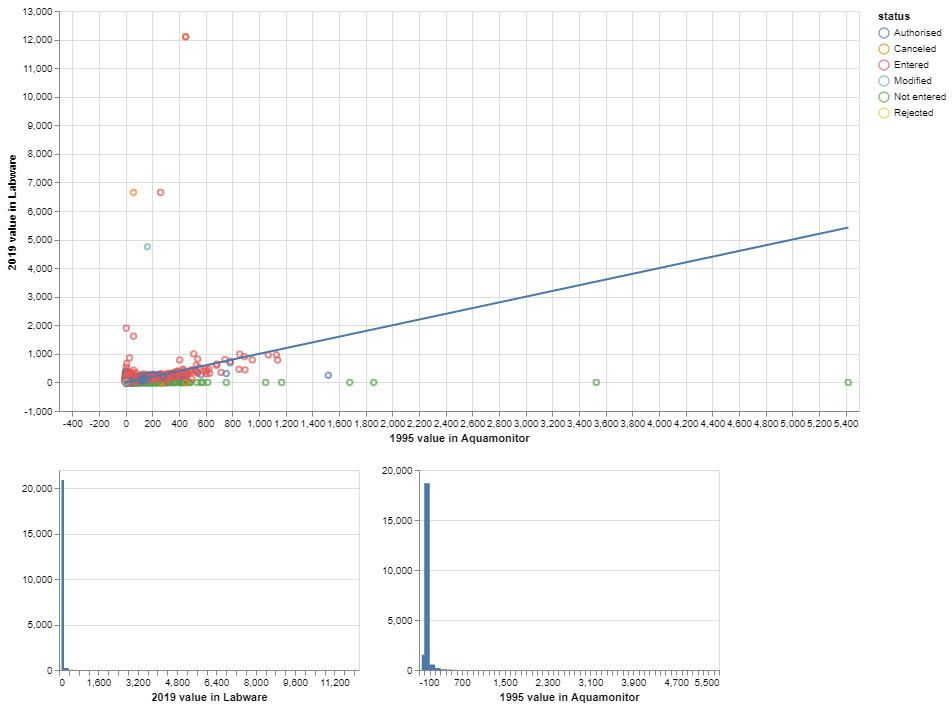

In [10]:
# Save data as JSON
alt.data_transformers.enable('json')

# Build drop-down list
par_list = ['None'] + sorted(df['parameter'].unique())
input_dropdown = alt.binding_select(options=par_list)
selection = alt.selection_single(fields=['parameter'], bind=input_dropdown, name='Select')

# Scatter plot
scatter = alt.Chart(df, height=400, width=800).mark_point().encode(
    x=alt.X('value_am:Q', title='1995 value in Aquamonitor'),
    y=alt.Y('value_lw:Q', title='2019 value in Labware'),
    tooltip=['station_id:N', 'station_name:N', 'sample_date:T', 'status:N'],
    color='status:N',
).add_selection(
    selection
).transform_filter(
    selection
).interactive()

# 1:1 line
line = alt.Chart(df, height=400, width=800).mark_line().encode(
    x=alt.X('value_am:Q', title=''),
    y=alt.Y('value_am:Q', title=''),
).transform_filter(
    selection
)

# Labware histogram
lw_hist = alt.Chart(df, height=200, width=300).mark_area(
    interpolate='step'
).encode(
    x=alt.X("value_lw:Q", bin=alt.Bin(maxbins=100), title='2019 value in Labware'),
    y=alt.Y('count()', title=''),
).transform_filter(
    selection
)

# Am histogram
am_hist = alt.Chart(df, height=200, width=300).mark_area(
    interpolate='step'
).encode(
    x=alt.X("value_am:Q", bin=alt.Bin(maxbins=100), title='1995 value in Aquamonitor'),
    y=alt.Y('count()', title=''),
).transform_filter(
    selection
)

# Layout
chart = (scatter + line) & (lw_hist | am_hist)
chart.save('qc_1000_lakes.json')

chart

## 9. Update `index.html`

In [18]:
# Build new text
today = dt.datetime.today()
today = today.strftime('%d.%m.%Y')
new_text = f'Labware results were last updated {today}'

# Update HTML. See https://stackoverflow.com/a/42882971/505698
soup = BeautifulSoup(open('index.html'), 'html.parser')
h3 = soup.find('h3')
h3.string.replace_with(new_text)

with open('index.html', 'w') as file:
    file.write(str(soup))